In [1]:
from typing import List, Tuple

import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt, colors, cm
from c3.experiment import Experiment
from c3.libraries.chip import Drive
from c3.parametermap import ParameterMap
from c3.model import Model
from c3.signal.gates import Instruction
import four_level_transmons.plotting as plotting
import four_level_transmons.utilities as utilities
import four_level_transmons.notebook_utils as notebook_utils
import scipy.linalg
import string
from c3.utils import qt_utils
from c3.libraries import constants
import four_level_transmons.custom_gates as custom_gates
from c3.utils import tf_utils
from c3.generator.generator import Generator

plt.rcParams["pdf.use14corefonts"] = True
np.set_printoptions(linewidth=300)

2023-10-26 16:42:41.646582: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-10-26 16:42:41.646608: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Input files

In [7]:
#baseDir = '/home/user/Schreibtisch/results/4-level qubit/two transmons/Fourier basis 5 levels, 1000ns/CZ/10/'
baseDir = '/home/user/Schreibtisch/results/4-level qubit/two transmons/fourier basis/1000ns/CZ neu/10/'
propagator = np.load(baseDir + 'propagator_after.npy')
#propagatorShort = np.load(baseDir + 'propagator_after_0.01ns.npy')
hamiltonian = np.load(baseDir + 'hamiltonian_timedependent_after.npy')
time, signal = np.load(baseDir + 'signal_t1_after.npy')
#_, entropy = np.load(baseDir + '/home/user/Schreibtisch/results/4-level qubit/2 LOs/1 transmon/iCNOT/entanglement_after.npy',allow_pickle=True)

### Helper functions and preparation

In [8]:
def getModel(isDressed=False, addDrives=False) -> Model:
    qubit_levels = [5, 5]
    qubit_frequencies = [5e9, 4.5e9]
    anharmonicities = [-300e6, -250e6]
    t1s = [25e-6, 25e-6]
    t2stars = [35e-6, 35e-6]
    qubit_temps = 50e-3
    couplingStrength = 20e6
    qubits = utilities.createQubits(qubit_levels, qubit_frequencies, anharmonicities, t1s, t2stars, qubit_temps)
    coupling = utilities.createChainCouplings([couplingStrength], qubits)
    if addDrives:
        drives = utilities.createDrives(qubits)
        coupling = coupling + drives
    model = Model(qubits, coupling)
    model.set_lindbladian(False)
    model.set_dressed(isDressed)
    model.set_FR(False)
    return model


def getDriftHamiltonian(isDressed=False):
    return getModel(isDressed).get_Hamiltonian()


def cutSpectrum(frequencies, spectrum, limits):
    leftCut = np.argwhere(frequencies > limits[0]).flatten()
    leftIdx = leftCut[0] if len(leftCut) > 0 else 0
    rightCut = np.argwhere(frequencies < limits[1]).flatten()
    rightIdx = rightCut[-1] if len(rightCut) > 0 else -1
    return frequencies[leftIdx:rightIdx], spectrum[leftIdx:rightIdx]

### Reads a propagator from a file and plots it

Infidelity:  [0.08700675]


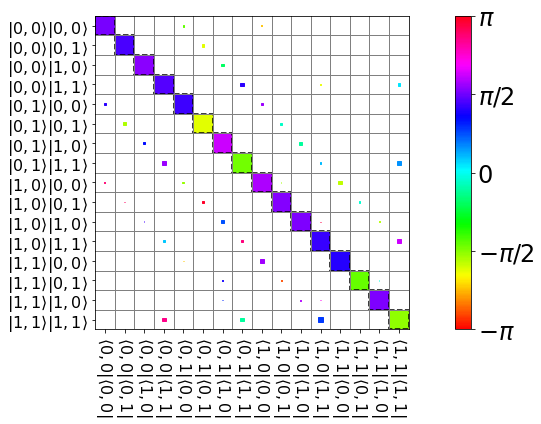

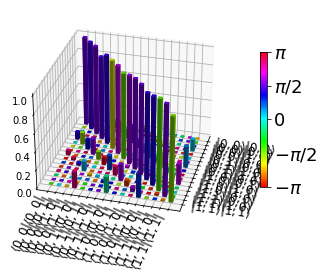

In [9]:
def plotPropagators():
    # Load and project the propagator
    propagatorProjected = tf_utils.tf_project_to_comp(
        propagator, dims=[5, 5], index=[0, 1], outdims=[4, 4]
    )

    # Define an ideal gate and compute the fidelity
    name = 'CZ'
    #ideal = qt_utils.np_kron_n([constants.GATES["rz90p"], constants.Id])
    #ideal = np.array([[1,0,0,-1j], [0,1,-1j,0], [0,-1j,1,0], [-1j,0,0,1]]) / np.sqrt(2.0)
    ideal = custom_gates.GATE_CZ_t1q2_t2q2
    #ideal = np.eye(16) + 0.0j * np.eye(16)
    idealPadded = qt_utils.pad_matrix(ideal, propagator.shape[0] - ideal.shape[0], 'fulluni')
    print("Infidelity: ", 1.0 - tf_utils.tf_unitary_overlap(propagatorProjected, ideal).numpy())

    # Correct the global phase in the propagator, which might be different from the ideal gate
    phase = np.angle(ideal[0, 0]) - np.angle(propagator[0, 0])
    propagatorCorrected = propagator * np.exp(1.0j * phase)
    propagatorCorrectedProjected = tf_utils.tf_project_to_comp(
        propagatorCorrected, dims=[5, 5], index=[0, 1], outdims=[4, 4]
    )

    baseDir = "/home/user"
    #plotting.plotComplexMatrixHinton(ideal, maxAbsolute=1, xlabels=level_labels_bra, ylabels=level_labels_ket,
    #                                 gridColour="gray", colourMap='hsv', tickLabelSize=16)
    #plotting.plotComplexMatrixHinton(propagator, maxAbsolute=1,
    #                                 xlabels=utilities.createTwoTransmonsQubitLabels(makeLatexBras=True, labelLeakageAsNumbers=False),
    #                                 ylabels=utilities.createTwoTransmonsQubitLabels(makeLatexKets=True, labelLeakageAsNumbers=False), gridColour="gray",
    #                                 filename=f'{baseDir}/{name}_propagator.pdf', colourMap='hsv', tickLabelSize=16)
    plotting.plotComplexMatrixHinton(propagatorProjected, maxAbsolute=1,
                                     xlabels=utilities.createTwoTransmonsQubitLabels(makeLatexBras=True, includeLeakage=False),
                                     ylabels=utilities.createTwoTransmonsQubitLabels(makeLatexKets=True, includeLeakage=False), gridColour="gray",
                                     filename=f'{baseDir}/{name}_propagator.pdf', colourMap='hsv', tickLabelSize=16,
                                     comparisonMatrix=ideal)
    plotting.plotComplexMatrix(propagatorProjected, colourMap='hsv',
                               xlabels=utilities.createTwoTransmonsQubitLabels(makeLatexBras=True, includeLeakage=False),
                               ylabels=utilities.createTwoTransmonsQubitLabels(makeLatexKets=True, includeLeakage=False),
                               filename='/home/user/rx90p_q2_propagator_3d.pdf')
    #maxz = np.max(np.absolute(propagatorCorrectedProjected - ideal))
    #plotting.plotComplexMatrix(propagatorCorrectedProjected - ideal, xlabels=utilities.createTwoTransmonsQubitLabels(makeLatexKets=True, includeLeakage=False),
    #                           ylabels=utilities.createTwoTransmonsQubitLabels(makeLatexBras=True, includeLeakage=False), filename=f'/home/user/{name}_propagator_diff.pdf',
    #                           colourMap='hsv', zlimits=(0.0, 0.1), zticks=np.round(np.arange(0.0, maxz, maxz / 5), 2))
plotPropagators()

### Reads a time dependent signal and plots it

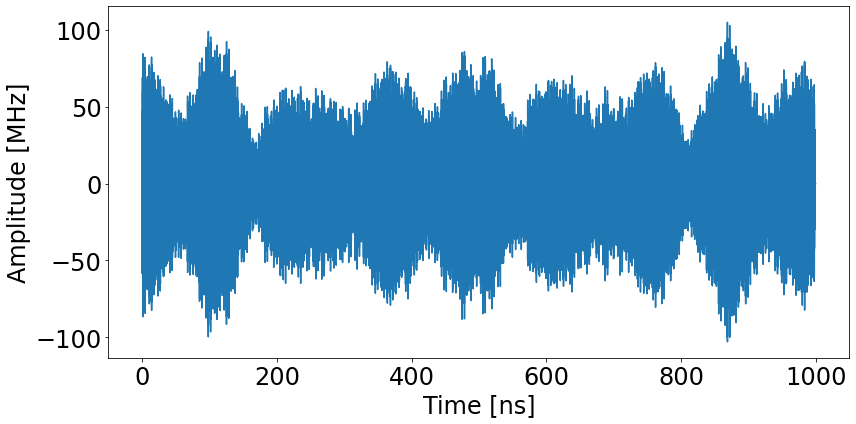

In [10]:
# Plots the time-dependent signal from a file
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
ax.plot(time * 1e9, signal / 1e6)
ax.set_xlabel("Time [ns]", fontsize=24)
ax.set_ylabel("Amplitude [MHz]", fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=24)
plt.tight_layout()
plt.savefig('/home/user/cz_1000ns_signal.pdf', bbox_inches="tight", dpi=100)
plt.show()

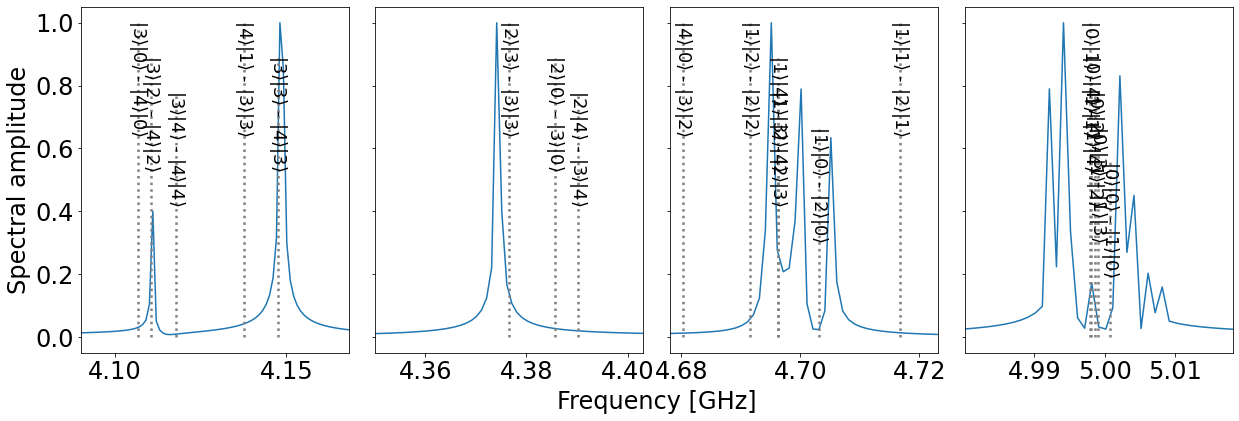

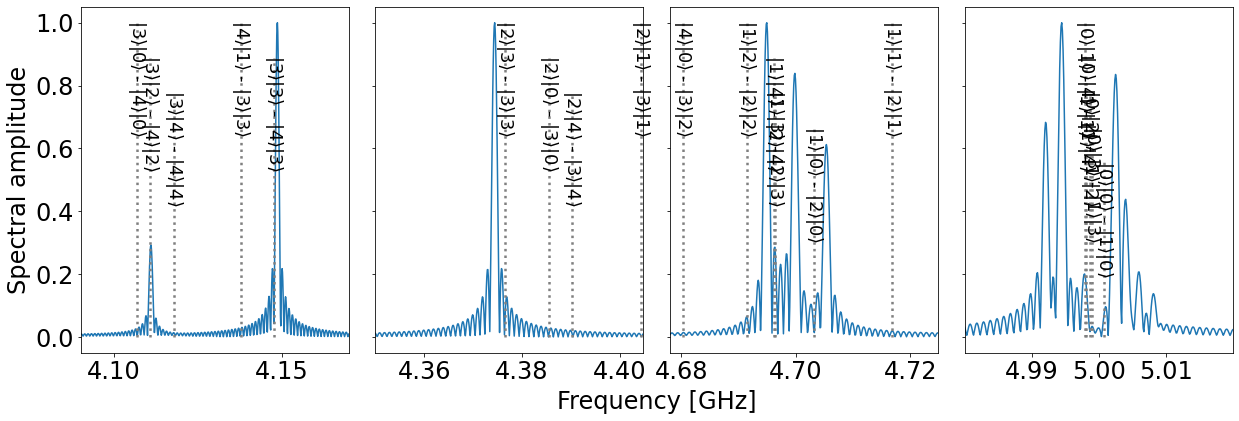

In [12]:
def createSpectrumPlot(ax, freq: np.array, freq_signal: np.array, addYAxis: bool = True) -> None:
    ax.plot(freq / 1e9, np.abs(freq_signal))
    #plt.plot(freq / 1e9, freq_signal.real, label="real")
    #plt.plot(freq / 1e9, freq_signal.imag, label="imag")

    #ax.set_xlabel("Frequency [GHz]", fontsize=24)
    if addYAxis:
        ax.set_ylabel("Spectral amplitude", fontsize=24)

    ax.set_xlim(np.min(freq) / 1e9, np.max(freq) / 1e9)
    #ax.set_ylim(-0.01 * np.max(np.abs(freq_signal)), 1.05 * np.max(np.abs(freq_signal)))
    #ax.set_ylim(-0.05, 1.1)

    ax.tick_params(axis='both', which='major', labelsize=24)

def plotEnergyLabels(ax, frequencyRange: Tuple[float, float], freq_signal: np.array) -> None:
    # Calculate all resonances
    #stateEnergies = notebook_utils.getEnergiesFromPropagator(propagatorShort, t_final=1e-11, dt=1e-12)
    H = hamiltonian[int(hamiltonian.shape[0]/2)]
    stateEnergies = notebook_utils.getEnergiesFromHamiltonian(H)
    #print("Stark shift: ", np.array(notebook_utils.getEnergiesFromHamiltonian(getDriftHamiltonian())) - np.array(stateEnergies))
    transitions = notebook_utils.calculateTransitions(stateEnergies, utilities.createTwoTransmonsStateLabels(makeLatexKets=True))

    # only transitions within a range
    inRange = [s for s in transitions if frequencyRange[0] < s[0] < frequencyRange[1]]
    energies = np.array([s[0] for s in inRange])
    labels = np.array([s[1] for s in inRange])
    sortedIndices = np.argsort(energies)
    sortedEnergies = energies[sortedIndices]

    # a tick for each transition energy
    ymax = np.max(np.abs(freq_signal))
    transitionSpacing = (frequencyRange[1] - frequencyRange[0]) / 5
    previousShifted = 0
    for i, E in enumerate(sortedEnergies):
        if i > 0 and abs(sortedEnergies[i] - sortedEnergies[i - 1]) < transitionSpacing:
            y = ymax * ((8.0 - previousShifted) / 9)
            previousShifted = (previousShifted + 1) % 4
        else:
            y = ymax
            previousShifted = 0
        ax.vlines(sortedEnergies[i] / 1e9, 0.0, y, colors=["grey"], linestyles=":", lw=2.5)
        ax.annotate(
            text=labels[sortedIndices[i]],
            xy=(E / 1e9, 1.01 * y),
            xycoords="data",
            verticalalignment="top",
            horizontalalignment="center",
            rotation=270,
            fontsize=18
        )

def plotSpectrum(time: np.array, signal: np.array, frequencyRanges: List[Tuple[float, float]], normalise=False, addLabels=True,
                 nthOrder=1, paddingFactor=1, filename=None) -> None:
    fig = plt.figure(figsize=(20, 6))
    axes = fig.subplots(1, len(frequencyRanges), sharey=True)
    if len(frequencyRanges) == 1:
        axes = [axes]

    # Pad the signal with zeros for better resolution
    if paddingFactor != 1:
        time2 = np.arange(time[0], paddingFactor*time[-1], time[1]-time[0])
        signal2 = np.zeros(int(paddingFactor*len(signal)))
        signal2[0:len(signal)] = signal
    else:
        time2 = time
        signal2 = signal

    # Calculate the spectrum
    freq_signal = np.fft.rfft(signal2)
    freq = np.fft.rfftfreq(len(time2), time2[-1] / len(time2))
    #freq_signal = freq_signal[:len(freq_signal)//2]
    #freq = freq[:len(freq)//2]
    freq *= nthOrder

    for plotIdx, frequencyRange in enumerate(frequencyRanges):
        freq2, freq_signal2 = cutSpectrum(freq, freq_signal, frequencyRange)
        if normalise:
            freq_signal2 /= np.max(np.abs(freq_signal2))

        #ax = fig.add_subplot(100 + (10*len(frequencyRanges) + (plotIdx+1)), sharey=True)
        ax = axes[plotIdx]
        createSpectrumPlot(ax, freq2, freq_signal2, addYAxis=(plotIdx==0))
        if addLabels:
            plotEnergyLabels(ax, frequencyRange, freq_signal2)

    #plt.tight_layout()
    fig.text(0.5, -0.03, 'Frequency [GHz]', ha='center', fontsize=24)
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.1, hspace=0.1)
    if filename is not None:
        plt.savefig(filename, bbox_inches="tight", dpi=100)
    plt.show()

rangeFullT1 = (3.94e9, 4.65e9)
rangeFullT2 = (3.95e9, 4.58e9)
rangesT1 = [(3.975e9, 4.05e9), (4.475e9, 4.6e9)]
rangesT2 = [(3.975e9, 4.03e9), (4.47e9, 4.525e9)]
#(4.44e9, 4.65e9)

#for order in range(1, 4):
#    for r in range(len(rangesT2)):
#        plotSpectrum(time, signal, (rangesT2[r][0]*order, rangesT2[r][1]*order), addLabels=True, nthOrder=order,
#        filename=f'/home/user/range{r+1}_order{order}.pdf')
plotSpectrum(time, signal, [(4.09e9, 4.17e9), (4.35e9, 4.405e9), (4.678e9, 4.725e9), (4.98e9, 5.02e9)], addLabels=True, nthOrder=1, normalise=True, filename="/home/user/cz_1000ns_spectrum1.pdf", paddingFactor=1.0)
plotSpectrum(time, signal, [(4.09e9, 4.17e9), (4.35e9, 4.405e9), (4.678e9, 4.725e9), (4.98e9, 5.02e9)], addLabels=True, nthOrder=1, normalise=True, filename="/home/user/cz_1000ns_spectrum2.pdf", paddingFactor=10)
#plotSpectrum(time, signal, [(4.0e9, 6.0e9)], addLabels=True, nthOrder=1, normalise=True, filename=None)
#plotSpectrum(time, signal, [(4.98e9, 5.02e9)], addLabels=True, nthOrder=1, normalise=True, filename=None)

In [ ]:
def plotEnergyDiamond(energies: np.array):
    model = getModel(True, False)
    #energies = model.eigenframe.numpy()/np.pi/2e9
    energies /= 1e9
    fig, ax = plt.subplots(1, figsize=(10, 10))
    for ii, states_tuples in enumerate(model.state_labels):
        manifold = sum(states_tuples)
        ax.plot(
            [states_tuples[0]-0.5-0.5*manifold, states_tuples[0]+0.5-0.5*manifold],
            [energies[ii], energies[ii]],
            c='black'
        )
        ax.text(
            states_tuples[0]-0.5*manifold, energies[ii]-0.5, states_tuples,
            horizontalalignment='center', verticalalignment="top", fontsize='16'
        )
    ax.set_ylim(-3, energies[-1]*1.1)
    ax.set_ylabel("Frequency [GHz]", fontsize=18)
    ax.set_xlim(-0.4*manifold, 0.4*manifold)
    plt.savefig('/home/user/diamond.svg')

allStateEnergies = notebook_utils.getEnergiesFromPropagator(propagatorShort, t_final=1e-11, dt=1e-12)
plotEnergyDiamond(allStateEnergies)

### Reads the time dependent entanglement entropy of a gate and plots it

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.plot(time * 1e9, entropy[:-1], color='black')

ax.set_xlabel("Time [ns]", fontsize=14)
ax.set_ylabel("Entropy [MHz]", fontsize=14)
ax.set_ylim(0, 1.01)

plt.tight_layout()
plt.savefig('/home/user/rz90p_q2_signal.pdf', bbox_inches="tight", dpi=100)
plt.show()